In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

# import sklearn
import warnings
warnings.filterwarnings("ignore")

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import sum, mean

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)


In [46]:
sdf = spark.read.parquet('../data/aggregated_results2.parquet/')
df = sdf.toPandas()
df.tail()

,PULocationID,DOLocationID,hour,count
543825,20,18,5,1
543826,167,169,14,1
543827,89,49,3,1
543828,223,89,21,1
543829,146,60,14,1


In [47]:
# read in and clean the population data
# population by boroughs
population_df = pd.read_csv("../data/NewYorkPopulation.csv")
# remove all the missing values
population_df.dropna(inplace=True)
# handling this dataframe
population_data = list(population_df.groupby("Borough")["2010 Population"].sum())
boroughs = ["Bronx","Brooklyn", "Manhattan", "Queens", "Staten Island"]

population_df = pd.DataFrame()
population_df["Borough"] = boroughs
population_df["population"] = population_data
population_df

,Borough,population
0,Bronx,1380697
1,Brooklyn,2504609
2,Manhattan,1577385
3,Queens,2241021
4,Staten Island,467968


In [48]:
# load shapefile of the boroughs
borough_sf = gpd.read_file("../data/Borough Boundaries/geo_export.shp")
borough_sf['geometry'] = borough_sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
pop_gdf = gpd.GeoDataFrame(pd.merge(population_df, borough_sf, left_on='Borough', right_on='boro_name')) \
                        .drop('boro_name',axis=1)


In [49]:
# plot population map
geoJSON = pop_gdf[['Borough','geometry']].to_json()

m = folium.Map(location=[40.66, -73.94], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m) # hide the tiles

folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=pop_gdf,
    columns=["Borough", "population"],
    key_on="properties.Borough",
    fill_color="OrRd",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name="population",
).add_to(m)

# add labels for each zone as another layer to the map so that the map becomes interactive now
# specify the setting
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
labels = folium.features.GeoJson(
    pop_gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Borough','population'],
        aliases=['District: ','population'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 10px; padding: 8px;") 
    )
)
m.add_child(labels)
m.keep_in_front(labels)
folium.LayerControl().add_to(m)


m.save('../plots/population.html')
# m

In [50]:
# prepare data for plotting dropoff locations map
do_location_df = sdf.groupBy("DOLocationID").sum("count") \
                     .withColumnRenamed("sum(count)", "num_trips") \
                     .toPandas()

do_location_df["log_num_trips"] = np.log(do_location_df["num_trips"])

In [51]:
sf = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zone = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")

sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(pd.merge(do_location_df, sf, left_on='DOLocationID', right_on='LocationID')) \
                        .drop('LocationID',axis=1)


In [52]:
# plot overall drop off locations distribution map
geoJSON = gdf[['DOLocationID','geometry','zone']].to_json()

m = folium.Map(location=[40.66, -73.94], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m) # hide the tiles

folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=gdf,
    columns=["DOLocationID", "log_num_trips"],
    key_on="properties.DOLocationID",
    fill_color="OrRd",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name="log(trip_num)",
).add_to(m)

# add labels for each zone as another layer to the map so that the map becomes interactive now
# specify the setting
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
labels = folium.features.GeoJson(
    gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['zone','num_trips'],
        aliases=['District: ','log(#trips)'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 10px; padding: 8px;") 
    )
)
m.add_child(labels)
m.keep_in_front(labels)
folium.LayerControl().add_to(m)


m.save('../plots/dropoff.html')
# m

In [53]:
zone = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")
# join the two dataframes by location ID and extract new column of the borough names
df = pd.merge(df, zone, left_on="PULocationID", right_on="LocationID") \
        .drop(columns=["Zone", "service_zone", "LocationID"])
df.rename(columns = {'Borough':'Pickup_Borough'}, inplace = True)
df = pd.merge(df, zone, left_on="DOLocationID", right_on="LocationID") \
        .drop(columns=["Zone", "service_zone", "LocationID"])
df.rename(columns = {'Borough':'Dropoff_Borough'}, inplace = True)
df.tail()

,PULocationID,DOLocationID,hour,count,Pickup_Borough,Dropoff_Borough
543825,127,199,13,1,Manhattan,Bronx
543826,199,199,19,1,Bronx,Bronx
543827,199,199,20,3,Bronx,Bronx
543828,199,199,17,1,Bronx,Bronx
543829,199,199,18,2,Bronx,Bronx


In [54]:
# Remove all the "unknown" boroughs
data = df.loc[df['Pickup_Borough'] != "Unknown"]
data = data.loc[df['Dropoff_Borough'] != "Unknown"]

data = data.groupby(["Pickup_Borough", "Dropoff_Borough"])["count"].sum()
data = np.log(data)
data

Pickup_Borough  Dropoff_Borough
Bronx           Bronx              11.014736
                Brooklyn            8.791486
                EWR                 3.258097
                Manhattan          10.736071
                Queens              8.981933
                Staten Island       4.897840
Brooklyn        Bronx               9.050641
                Brooklyn           13.237405
                EWR                 6.685861
                Manhattan          12.552371
                Queens             11.012496
                Staten Island       7.094235
EWR             Bronx               0.693147
                Brooklyn            1.945910
                EWR                 8.723069
                Manhattan           4.804021
                Queens              3.555348
                Staten Island       1.609438
Manhattan       Bronx              12.843691
                Brooklyn           14.534547
                EWR                11.979699
                Manhatt

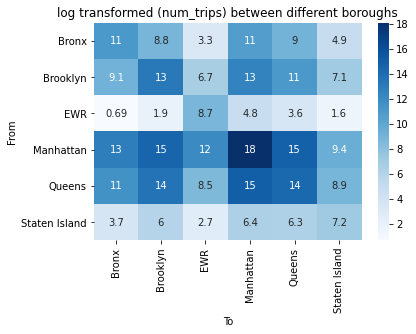

In [55]:
# Creat a heatmap to show the movements between different boroughs
labels = ["Bronx","Brooklyn" ,"EWR", "Manhattan", "Queens", "Staten Island"]
matrix = []
p = 0
for i in range(6):
    row = []
    for j in range(6):
        row.append(data[p])
        p += 1
    matrix.append(row)
ax = sns.heatmap(data=matrix, cmap="Blues",xticklabels=labels,
                yticklabels= labels, annot=True)
plt.ylabel("From")
plt.xlabel("To")
plt.title("log transformed (num_trips) between different boroughs")
plt.savefig("../plots/heatmap.png", bbox_inches = 'tight')
plt.close()

In [56]:
# Plot droppoffs from 4pm to 12am
# filter the data
# exclude "EWR"
data = df.loc[(df['Dropoff_Borough'] != "Unknown") 
                & (df['Dropoff_Borough'] != "EWR")
                & ((df["hour"] >= 16) | (df["hour"] == 0))]

data = data[["Dropoff_Borough", "count"]]
# aggregate the data
trip_data = list(data.groupby("Dropoff_Borough")["count"].sum())
data = pd.DataFrame()
data["Borough"] = boroughs
data["trip_num"] = trip_data
data["log_trip_num"] = np.log(data["trip_num"])
# data

gdf = gpd.GeoDataFrame(pd.merge(data, borough_sf, left_on='Borough', right_on='boro_name')) \
                        .drop('boro_name',axis=1)
geoJSON = gdf[['Borough','geometry']].to_json()
m = folium.Map(location=[40.66, -73.94], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)

folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=gdf,
    columns=["Borough", "log_trip_num"],
    key_on="properties.Borough",
    fill_color="OrRd",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name="log(number of trips) at 16:00-1:00",
).add_to(m)

labels = folium.features.GeoJson(
    gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Borough','log_trip_num'],
        aliases=['District: ','log_trip_num'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 10px; padding: 8px;") 
    )
)
m.add_child(labels)
m.keep_in_front(labels)
folium.LayerControl().add_to(m)

m.save('../plots/dropoff_after4.html')
# m

In [57]:
#  Plot pickups between 6:00-10:00
# filter the data
# exclude "EWR"
data = df.loc[(df['Pickup_Borough'] != "Unknown") 
                & (df['Pickup_Borough'] != "EWR")
                & ((df["hour"] >= 6) | (df["hour"] <= 9))]

data = data[["Pickup_Borough", "count"]]
# aggregate the data
trip_data = list(data.groupby("Pickup_Borough")["count"].sum())
data = pd.DataFrame()
data["Borough"] = boroughs
data["trip_num"] = trip_data
data["log_trip_num"] = np.log(data["trip_num"])
# data

gdf = gpd.GeoDataFrame(pd.merge(data, borough_sf, left_on='Borough', right_on='boro_name')) \
                        .drop('boro_name',axis=1)
geoJSON = gdf[['Borough','geometry']].to_json()
m = folium.Map(location=[40.66, -73.94], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(m)

folium.Choropleth(
    geo_data=geoJSON,
    name="choropleth",
    data=gdf,
    columns=["Borough", "log_trip_num"],
    key_on="properties.Borough",
    fill_color="OrRd",
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name="log(number of trips) for 6:00-10:00",
).add_to(m)

labels = folium.features.GeoJson(
    gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['Borough','log_trip_num'],
        aliases=['District: ','log_trip_num'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 10px; padding: 8px;") 
    )
)
m.add_child(labels)
m.keep_in_front(labels)
folium.LayerControl().add_to(m)


m.save('../plots/pickup_morning.html')
# m

In [58]:
data = df.loc[(df['Pickup_Borough'] != "Unknown") 
                & (df['Pickup_Borough'] != "EWR")]

data = data[["Pickup_Borough", "count"]]
# aggregate the data
trip_data = list(data.groupby("Pickup_Borough")["count"].sum())
data = pd.DataFrame()
data["Borough"] = boroughs
data["trip_num"] = trip_data
data["log_trip_num"] = np.log(data["trip_num"])
data["population"] = population_data
data

,Borough,trip_num,log_trip_num,population
0,Bronx,124051,11.728448,1380697
1,Brooklyn,921830,13.734116,2504609
2,Manhattan,75704291,18.142345,1577385
3,Queens,5638943,15.545207,2241021
4,Staten Island,3057,8.025189,467968


parameters:  6.858497235806204 3.2754027120930585e-06
MSE:  0.9578409651225416
Coefficient of determination:  0.8771280480214078


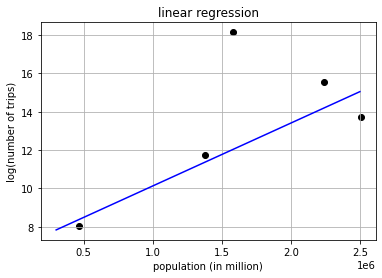

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Treat "Manhattan" as an outlier
X_data = np.array(data["population"], dtype=int)
X_data = np.delete(X_data,2)
y = np.array(data["log_trip_num"])
y = np.delete(y,2)
X = []
for i in range(4):
    X.append([1,X_data[i]])

# Fit a linear regression model with population as predictor and num of trips as response
reg = LinearRegression().fit(X, y)
beta1 = reg.coef_[1]
beta0 = reg.intercept_
x = np.linspace(300000, 2500000, 100)
y_pred = reg.predict(X)
print("parameters: ", beta0, beta1)
print("MSE: ", mean_squared_error(y, y_pred))
print('Coefficient of determination: ',r2_score(y, y_pred))
plt.scatter(data["population"], data["log_trip_num"], color='black')
y_pred = beta0 + beta1 * x
plt.plot(x, y_pred, color='blue')
plt.grid()
plt.title("linear regression")
plt.ylabel("log(number of trips)")
plt.xlabel("population (in million)")
plt.savefig("../plots/pop_numtrips.png", bbox_inches = "tight")